<a href="https://colab.research.google.com/github/Prateek190/-Media-Expressed-Negative-Tone-and-Predictability-of-Firm-Level-Stock-Returns/blob/main/VAR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse,aic

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

r=pd.read_csv("/content/drive/My Drive/stock/final_ADANIPORTS.NS.csv")
nt=pd.read_csv("/content/drive/My Drive/tone/pct730/pct730_adani.csv")
df=pd.DataFrame()
df['return']=r['return']
df['negative tone']=nt['PCT']
#df.set_index(r['Date'])
df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df.replace([np.inf, -np.inf], np.nan)

df.dropna(inplace=True)
df



,return,negative tone
0,0.00,1.42
1,-0.56,1.84
2,2.58,0.71
3,0.54,0.00
4,3.40,0.34
...,...,...
725,0.79,0.13
726,0.00,0.00
727,0.00,0.00
728,0.88,0.62


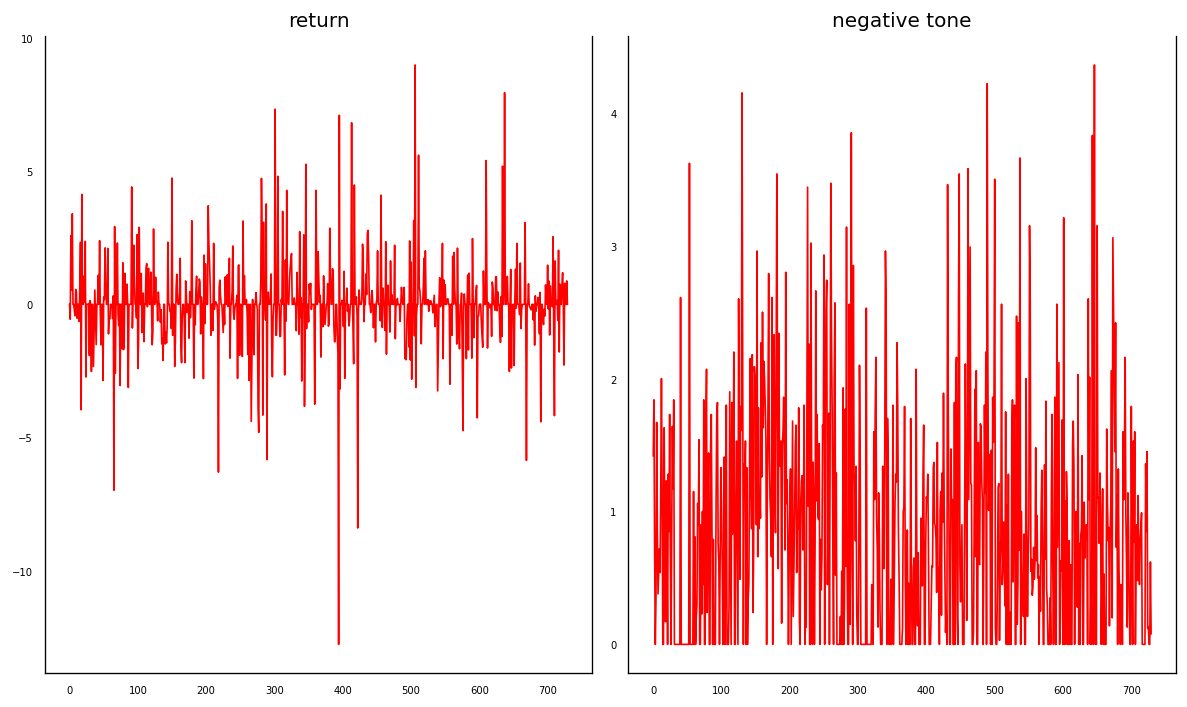

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,return_x,negative tone_x
return_y,1.0000,0.0702
negative tone_y,0.5363,1.0000


In [ ]:
# Results from Granger Casuality test can be read as : negative tone causes return (10% significance) but return do not causes negative tone.


In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
return ::  124.38    > 12.3212   =>   True
negative tone ::  15.43     > 4.1296    =>   True


In [ ]:
t = 73
df_train, df_test = df[0:-t], df[-t:]

# Check size
print(df_train.shape)  # (655, 2)
print(df_test.shape)  # (73, 2)


(655, 2)
(73, 2)


In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [ ]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.9091
 No. Lags Chosen       = 0
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "negative tone" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8233
 No. Lags Chosen       = 19
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0027. Rejecting Null Hypothesis.
 => Series is Stationary.




In [ ]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  0.81902967982193
BIC :  0.8601591050646565
FPE :  2.2682980861694197
HQIC:  0.8349783022984896 

Lag Order = 2
AIC :  0.8301486646777126
BIC :  0.8987792485869994
FPE :  2.2936610740458327
HQIC:  0.8567631781508723 

Lag Order = 3
AIC :  0.8302439840352321
BIC :  0.9264412599048228
FPE :  2.2938821269061935
HQIC:  0.8675512951411677 

Lag Order = 4
AIC :  0.836683657413489
BIC :  0.9605134171058919
FPE :  2.308705968800321
HQIC:  0.8847107813079753 

Lag Order = 5
AIC :  0.840912487550453
BIC :  0.9924407829097961
FPE :  2.318496582433985
HQIC:  0.8996865485075655 

Lag Order = 6
AIC :  0.8463507006147607
BIC :  1.0256438448895009
FPE :  2.331149326756972
HQIC:  0.9158989326297649 

Lag Order = 7
AIC :  0.855567250938669
BIC :  1.0626918202142375
FPE :  2.3527475006107466
HQIC:  0.9359169983351322 

Lag Order = 8
AIC :  0.8679147966998473
BIC :  1.1029376313413166
FPE :  2.3819964800495828
HQIC:  0.9590935147410102 

Lag Order = 9
AIC :  0.8812852950191035
BIC :  1

In [ ]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,0.8624,0.8763*,2.369,0.8678
1,0.8363*,0.8780,2.308*,0.8525*
2,0.8460,0.9154,2.330,0.8729
3,0.8471,0.9443,2.333,0.8848
4,0.8527,0.9777,2.346,0.9012
5,0.8603,1.013,2.364,0.9196
6,0.8635,1.044,2.372,0.9336
7,0.8694,1.078,2.386,0.9503
8,0.8792,1.115,2.409,0.9709
9,0.8902,1.154,2.436,0.9926


In [ ]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Dec, 2020
Time:                     14:30:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.782198
Nobs:                     723.000    HQIC:                  0.758843
Log likelihood:          -2314.80    FPE:                    2.10468
AIC:                     0.744161    Det(Omega_mle):         2.08732
--------------------------------------------------------------------
Results for equation return
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.117581         0.088341            1.331           0.183
L1.return               -0.126029         0.036904           -3.415           0.001
L1.negative tone        -0.126788         0.071

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))